# Predicting Speed Dating Success Using Various Personality Traits

## Introduction



Speed dating is a popular dating practice that involves meeting multiple potential partners in a short period of time. This practice has gained popularity in recent years due to its effectiveness in helping people find compatible partners.

In this proposal, we will attempt to answer the following question: What individual characteristics are most important in predicting the success of speed dating? By analyzing data from a speed dating dataset, we will attempt to identify which factors are most strongly associated with successful matches.

The dataset we use contains information from speed dating events held in different cities in the United States. It includes information on participants' demographic characteristics, such as age, education level, and ethnicity, as well as their responses to survey questions related to their personalities, interests, and dating preferences, and whether or not each individual was matched with their potential partner.



## Methods and Results

#### 1. Importing Libraries

We begin by installing and importing the required libraries for this analysis.

In [1]:
# Install packages
# install.packages('tidyverse')
# install.packages('tidymodels')
# install.packages('themis')
# install.packages('repr')
# install.packages('gridExtra')
# install.packages('grid')

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Importing libraries
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(gridExtra)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### 2. Reading the Data

Using the **read_csv()** function, we read the data from the source and store it in a variable. We perform a short analysis on the data, getting information about the number of columns, rows, as well as a preview of what each observation looks like. 

In [3]:
# Reading the data
speed_dating_data <- read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data.csv")

# Number of Rows and Columns
num_rows <- nrow(speed_dating_data)
num_cols <- ncol(speed_dating_data)

speed_dating_summary <- tibble(Rows = num_rows, 
                  Columns = num_cols)

# Previewing the data
speed_dating_preview <- head(speed_dating_data)

Rows: 8378 Columns: 195
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): field, undergra, from, career
dbl (187): iid, id, gender, idg, condtn, wave, round, position, positin1, or...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
speed_dating_summary
speed_dating_preview

Rows,Columns
<int>,<int>
8378,195


iid,id,gender,idg,condtn,wave,round,position,positin1,order,⋯,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,1,1,10,7,NA,4,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,3,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,10,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,5,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,7,⋯,5,7,7,7,7,NA,NA,NA,NA,NA
1,1,0,1,1,1,10,7,NA,6,⋯,5,7,7,7,7,NA,NA,NA,NA,NA


#### 3. Summary Discussion

[link]: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data%20Key.doc

From the speed dating dataset's [legend][link], we know there are many variables that are not useful in answering our research question, such as the individual's event ID, or the zipcode of where the individual was raised. There are many variables which do not use numerical values as well, such as the individual's career or field of study. Using 195 predictors would also be very computationally expensive, so we narrowed our possible predictors down to 6: attractiveness, sincerity, intelligence, funniness, and ambition. We chose these variables because they can be numerically rated, and are commonly discussed traits regarding relationships, and therefore would be variables to use to predict whether an individual would match with their partner or not. In step 6, we will further narrow down our predictors, by figuring out which variables have the highest correlation with whether or not the individual matches. 

#### 4. Tidying the Data

Our next step was to tidy the data into a state where we could easily use it to create our predictive model. We began by selecting the desired columns, and filtering out improper observations that could create future difficulties (N/A values, values that went by a different scale, etc.).

In [5]:
# Selecting desired rows
speed_dating_select <- speed_dating_data |>
    filter(wave != 6:9) |> # These waves had a different rating system for traits
    mutate(match = as_factor(match)) |>
    select(match, attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o)

# Filtering the data of improper observations
speed_dating_tidy <- speed_dating_select |>
    filter(attr_o %% 1 == 0,
          sinc_o %% 1 == 0,
          intel_o %% 1 == 0,
          fun_o %% 1 == 0,
          amb_o %% 1 == 0, 
          shar_o %% 1 == 0,
          fun_o <= 10)

# Renaming categorical values
levels(speed_dating_tidy$match)[2] <- "yes"
levels(speed_dating_tidy$match)[1] <- "no"

# Renaming columns
colnames(speed_dating_tidy) <- c("Match", "Attractiveness", "Sincerity", "Intelligence", "Funniness", "Ambition", "Shared_Interest")

# Preview of tidied dataset
head(speed_dating_tidy)

Warning message in wave != 6:9:
“longer object length is not a multiple of shorter object length”


Match,Attractiveness,Sincerity,Intelligence,Funniness,Ambition,Shared_Interest
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,6,8,8,8,8,6
no,7,8,10,7,7,5
yes,10,10,10,10,10,10
yes,7,8,9,8,9,8
yes,8,7,9,6,9,7
no,7,7,8,8,7,7


#### 5. Column Legend
- **Match**: Whether or not the individual matched with their partner
- **Attractiveness**: How attractive the individual was rated by their partner
- **Sincerity**: How sincere the individual was rated by their partner
- **Intelligence**: How intelligent the individual was rated by their partner
- **Funniness**: How funny the individual was rated by their partner
- **Ambition**: How ambitious the individual was rated by their partner
- **Shared_Interest**: How similar the individual and partner's interests are

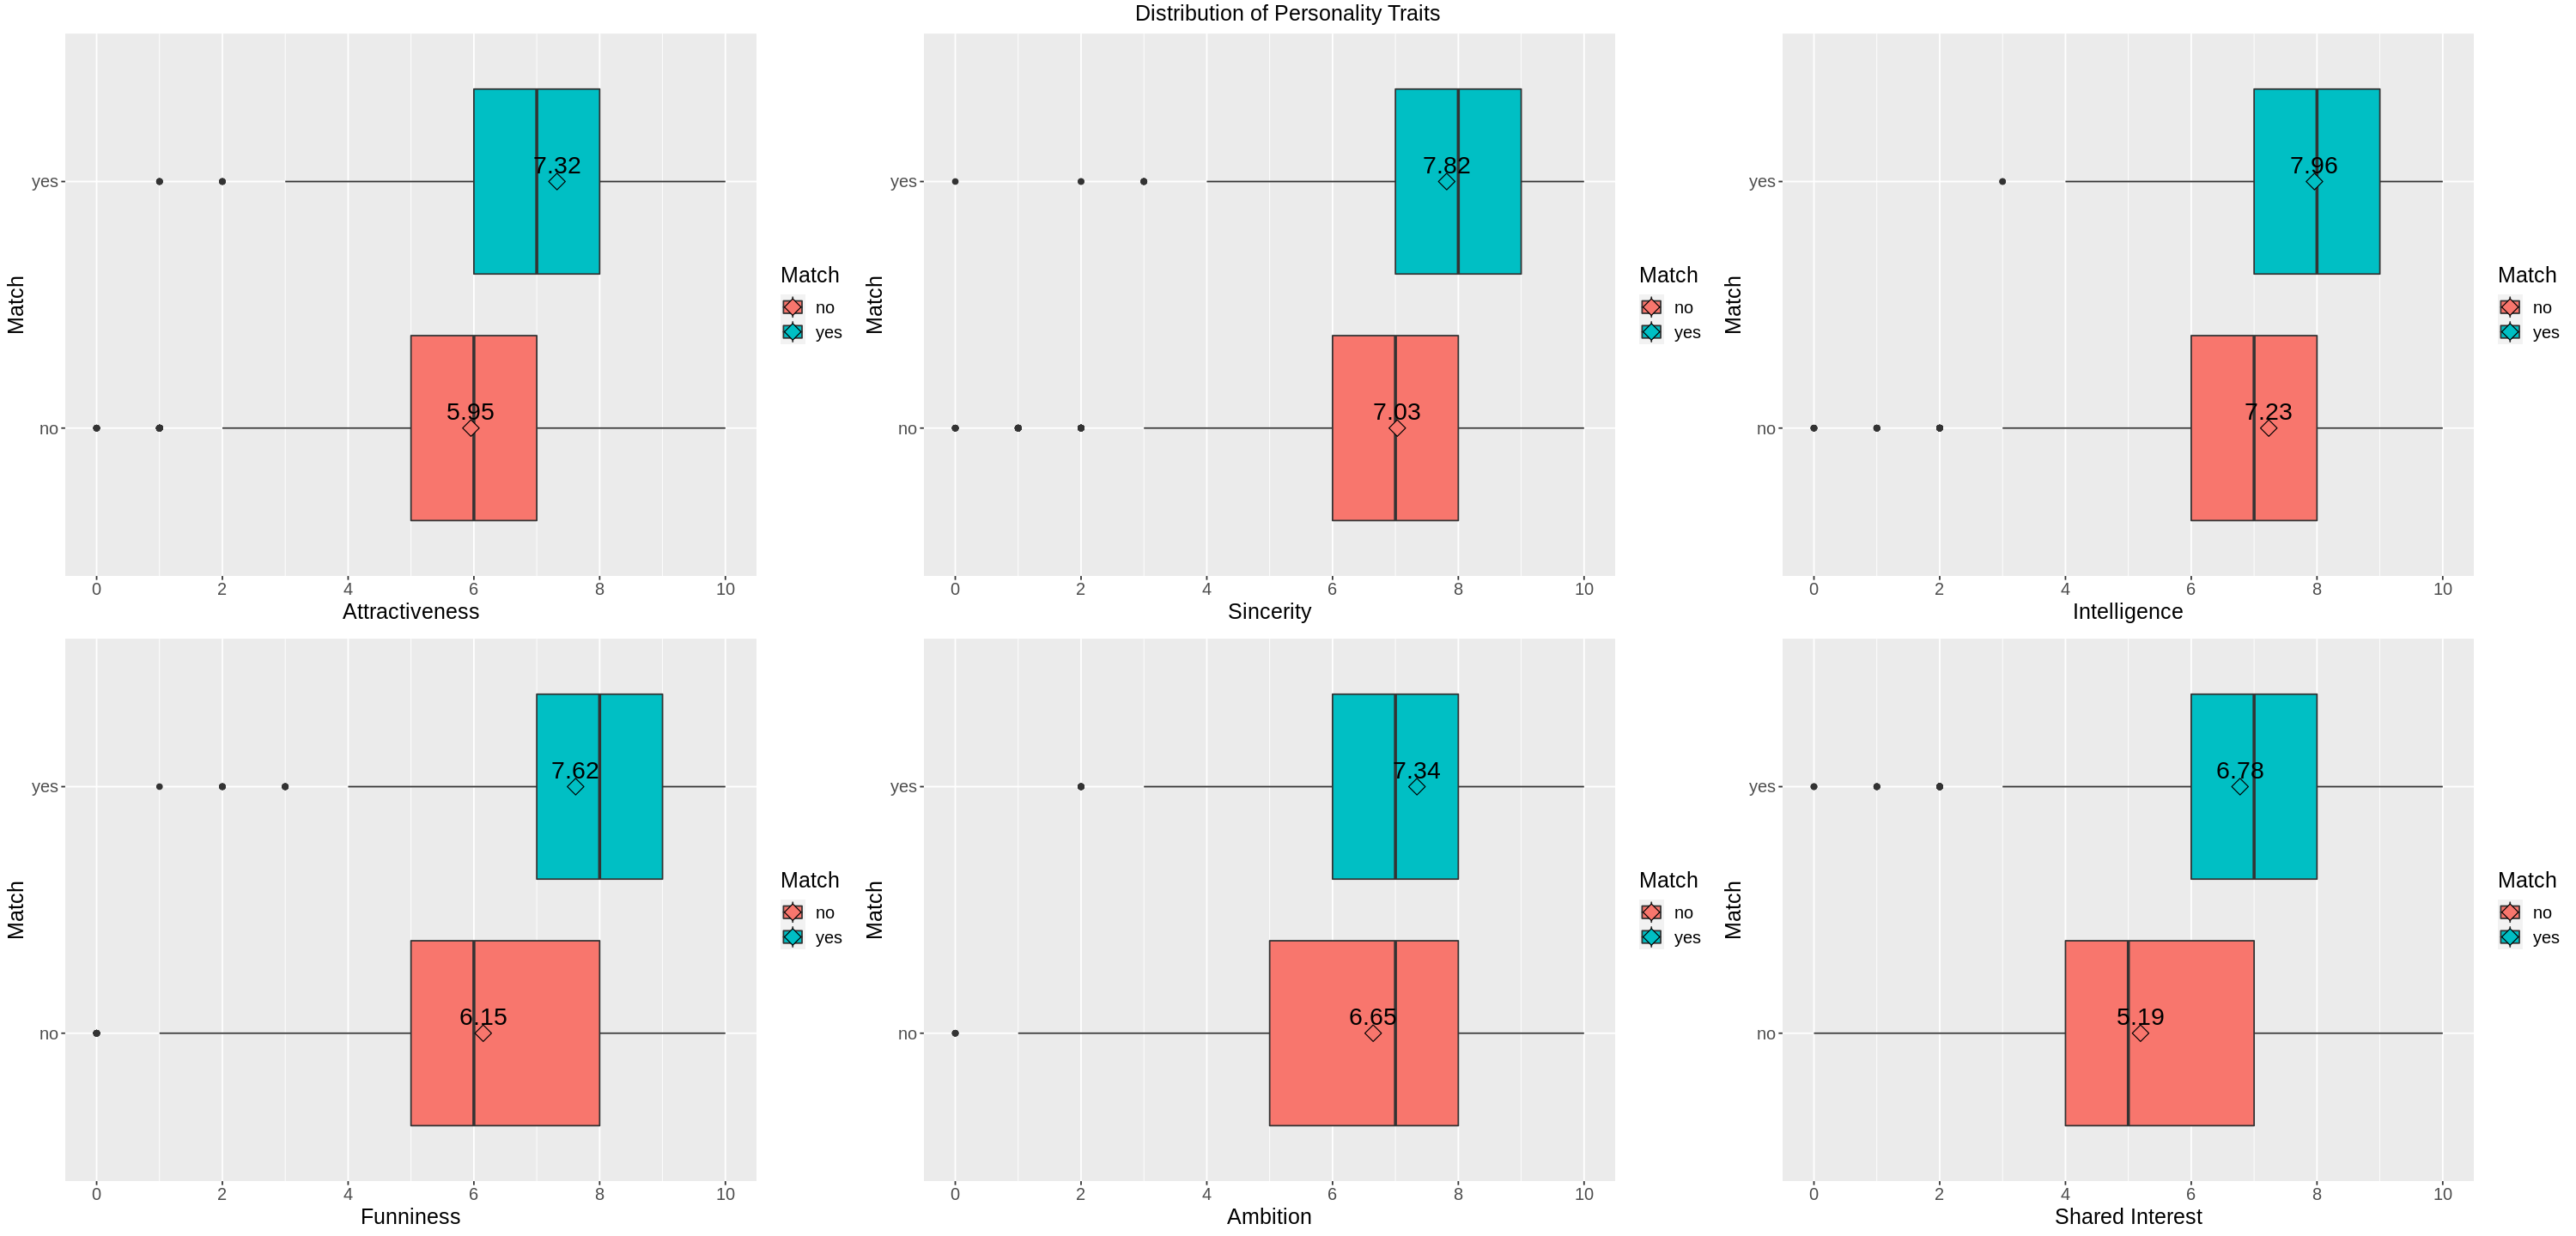

In [6]:
# Plotting
options(repr.plot.width=25, repr.plot.height=12)

attract_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Attractiveness, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Attractiveness", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

sincere_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Sincerity, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Sincerity", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

intel_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Intelligence, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Intelligence", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

funny_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Funniness, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Funniness", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

ambition_boxplot <- speed_dating_tidy |>
    ggplot(aes(x = Ambition, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Ambition", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

shared_interest_plot <- speed_dating_tidy |>
    ggplot(aes(x = Shared_Interest, y = Match, fill = Match)) + 
    geom_boxplot() +
    labs(x = "Shared Interest", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

grid.arrange(attract_boxplot, sincere_boxplot, intel_boxplot, funny_boxplot, ambition_boxplot, shared_interest_plot,
             nrow = 2, top = textGrob("Distribution of Personality Traits", gp=gpar(fontsize=15,font=8)))

#### 6. Variable Importance

By looking at the figure above, we can see that some variables clearly have a higher correlation with being matched than others. For example, the median funniness rating of those who matched was 8, while those who did not match had a median of 6, so clearly being more funny increases your chances of being matched. However, the median score for ambition of both those who matched and those who did not are both 7, implying that ambition has a weaker correlation with being matched. To get a better understanding of these relationships, we will take the difference of means of each trait between the groups who matched and the groups who didn't, and see which values have the largest difference, and therefore the strongest correlation with being matched.

In [7]:
# Taking means of each trait
speed_dating_means <- speed_dating_tidy |>
    group_by(Match) |>
    summarize(Mean_Attractiveness = mean(Attractiveness),
              Mean_Sincerity = mean(Sincerity),
              Mean_Intelligence = mean(Intelligence),
              Mean_Funniness = mean(Funniness),
              Mean_Ambition = mean(Ambition), 
              Mean_Shared_Interest = mean(Shared_Interest))
speed_dating_means

Match,Mean_Attractiveness,Mean_Sincerity,Mean_Intelligence,Mean_Funniness,Mean_Ambition,Mean_Shared_Interest
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,5.953032,7.029332,7.233399,6.148101,6.645852,5.193990
yes,7.321429,7.815331,7.959930,7.617596,7.342334,6.776132


Now that we have the means, we will take the difference between the observations that matched and the ones that did not, to see which has the largest correlation. 

In [8]:
# Means of observations that matched
speed_dating_yes <- speed_dating_means |>
    slice(1) |>
    select(-Match) 

# Means of observations that did not match
speed_dating_no <- speed_dating_means |>
    slice(2) |>
    select(-Match)

# Taking the difference of "yes" and "no" means
speed_dating_diffs <- abs(speed_dating_yes - speed_dating_no)

# Renaming columns
colnames(speed_dating_diffs) <- c("Attract_Diff", "Sincere_Diff", "Intel_Diff", "Funny_Diff", "Ambition_Diff", "Shared_Interest_Diff")

speed_dating_diffs

Attract_Diff,Sincere_Diff,Intel_Diff,Funny_Diff,Ambition_Diff,Shared_Interest_Diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.368396,0.7859986,0.726531,1.469494,0.6964824,1.582143


#### 7. Variable Discussion

From the table above, we observe that **attractiveness**, **funniness** and **shared interest** have a significantly stronger correlation with getting a match than the other traits. Therefore, we will create a model which only uses those 3 variables as predictors, as it will create a more accurate model.

#### 8. Creating the Classification Model

Now that we have concluded our exploratory data analysis, we can create our model, using the predictors that we selected.
We will be creating a K-Nearest Neighbours classification model to predict whether an observation will match or not. To begin, we will split the data into a training set and a testing set, with proportions of 75% and 25%, respectfully. 

In [9]:
# Setting a seed
set.seed(1000)

# Splitting the data
speed_dating_split <- initial_split(speed_dating_tidy, prop = 0.75, strata = Match)
speed_dating_train <- training(speed_dating_split)
speed_dating_test <- testing(speed_dating_split)

# Identifying class imbalance
speed_dating_train |>
    group_by(Match) |>
    summarize(n = n())

Match,n
<fct>,<int>
no,4167
yes,861


#### 9. Upsampling the Data

One issue with our dataset that was noticed is that there exists a class imbalance between the observations who matched and the ones who did not. Since we plan to use a K-Nearest Neighbours classifier, a class imbalance is quite problematic, as most of the neighbours will be ones that did not match, so the model will classify almost every observation as one that did not match. To fix this, we will upsample the minority class in the training class, so the model is trained with a balanced dataset.

In [10]:
# Prepping the recipe
upsample_recipe <- recipe(Match ~ Attractiveness + Funniness + Shared_Interest, data = speed_dating_train) |>
  step_upsample(Match, over_ratio = 1, skip = FALSE) |>
  prep()

# Baking a new training set
speed_dating_train_upsampled <- bake(upsample_recipe, speed_dating_train)

# Matches
speed_dating_train_upsampled |>
    group_by(Match) |>
    summarize(n = n())

Match,n
<fct>,<int>
no,4167
yes,4167


#### 10. Tuning the Model

Now that we have upsampled the training data, we can perform a **5 fold Cross Validation** on the training data, to find the optimal value of **K** to use in our model.

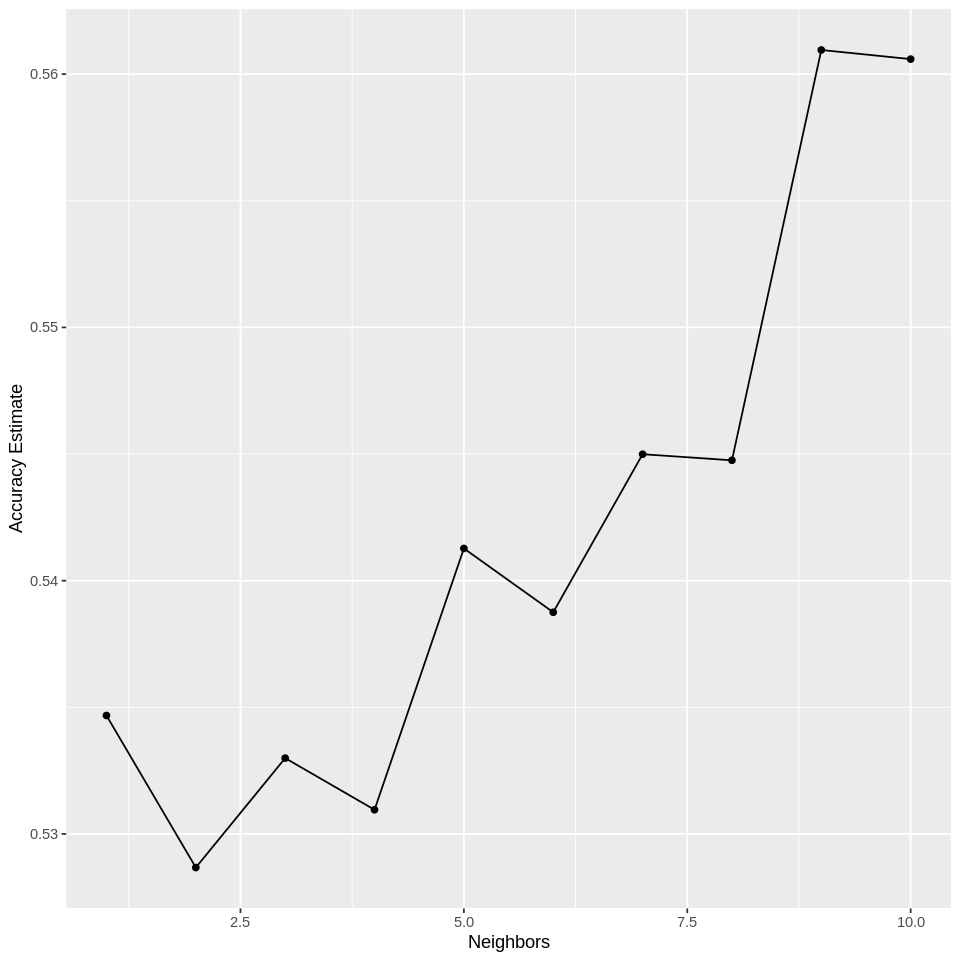

In [74]:
options(repr.plot.width=8, repr.plot.height=8)

# Setting a seed
set.seed(1000)

# Creating a tuning model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Creating the folds
speed_dating_vfold <- vfold_cv(data = speed_dating_train_upsampled, v = 5, strata = Match)

# K values that we would like to test
k_value <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# Creating an upsampled recipe
# Note: no need to scale, as all variables are rated from 0-10
speed_dating_recipe <- recipe(Match ~ Attractiveness + Funniness + Shared_Interest, data = speed_dating_train_upsampled)

# Performing the cross validation, and collecting the results
knn_results <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = speed_dating_vfold, grid = k_value) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy")

# Plotting the results
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

#### 11. Creating the Model

By observing the plot above and seeing which K value will result in the highest accuracy, we decide to create a K-NN Classification model which uses **9** neighbours. 

In [12]:
knn_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

speed_dating_fit <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_optimal) |>
    fit(data = speed_dating_train_upsampled)

#### 12. Testing the model

Now that we have created a model, we will test it on the testing set from before to analyze the accuracy of this model.

In [14]:
predictions <- predict(speed_dating_fit, speed_dating_test) |>
    bind_cols(speed_dating_test)

accuracies <- predictions |>
    metrics(truth = Match, estimate = .pred_class)

accuracy_matrix <- predictions |>
    conf_mat(truth = Match, estimate = .pred_class)

accuracies
accuracy_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8163387
kap,binary,0.1381633


          Truth
Prediction   no  yes
       no  1326  244
       yes   64   43

#### 13. Results

The results of our model show that it has around an 81% accuracy. Although this is not extremely accurate, it can be expected that the model will not be perfectly accurate, as the factors which determine whether someone matches or not are extremely subjective depending on each individual. By looking at the confusion matrix above, we see that many of the incorrect predictions were false negatives, and there were very little true positives. However, this tells us very little about what the incorrect predictions are caused by. By creating a plot of the incorrect predictions, we can get a better understanding of where our model went wrong.

In [112]:
# Tidying incorrect predictions
incorrect_predictions <- predictions |>
    filter(.pred_class != Match) |> 
    select(-.pred_class) 
levels(incorrect_predictions$Match)[2] <- "F_Neg"
levels(incorrect_predictions$Match)[1] <- "F_Pos"
colnames(incorrect_predictions) <- c("Class_Prediction", "Attractiveness", "Sincerity", "Intelligence", "Funniness", "Ambition", "Shared_Interest")

# Tidying testing set
actual_data <- speed_dating_test

# Binding datasets
speed_dating_predictions <- incorrect_predictions |>
    bind_rows(actual_data) 

In [138]:
# Plotting the sets
false_attr_plot <- incorrect_predictions |>
    ggplot(aes(x = Attractiveness, y = Class_Prediction, fill = Class_Prediction)) +
    geom_boxplot() +
    labs(x = "Attractiveness", y = "Class Prediction", fill = "Class_Prediction") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    expand_limits(x = 0) +
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

true_attr_plot <- actual_data |>
    ggplot(aes(x = Attractiveness, y = Match, fill = Match)) +
    geom_boxplot() +
    labs(x = "Attractiveness", y = "Match", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

false_funny_plot <- incorrect_predictions |>
    ggplot(aes(x = Funniness, y = Class_Prediction, fill = Class_Prediction)) +
    geom_boxplot() +
    labs(x = "Funniness", y = "Class Prediction", fill = "Class_Prediction") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

false_shar_plot <- incorrect_predictions |>
    ggplot(aes(x = Shared_Interest, y = Class_Prediction, fill = Class_Prediction)) +
    geom_boxplot() +
    labs(x = "Shared Interest", y = "Class Prediction", fill = "Class_Prediction") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15)) + 
    stat_summary(fun=mean, geom="point", shape=23, size=4) + 
    stat_summary(aes(label=round(..x..,2)), fun=mean, geom="text", size=6, vjust = -0.5)

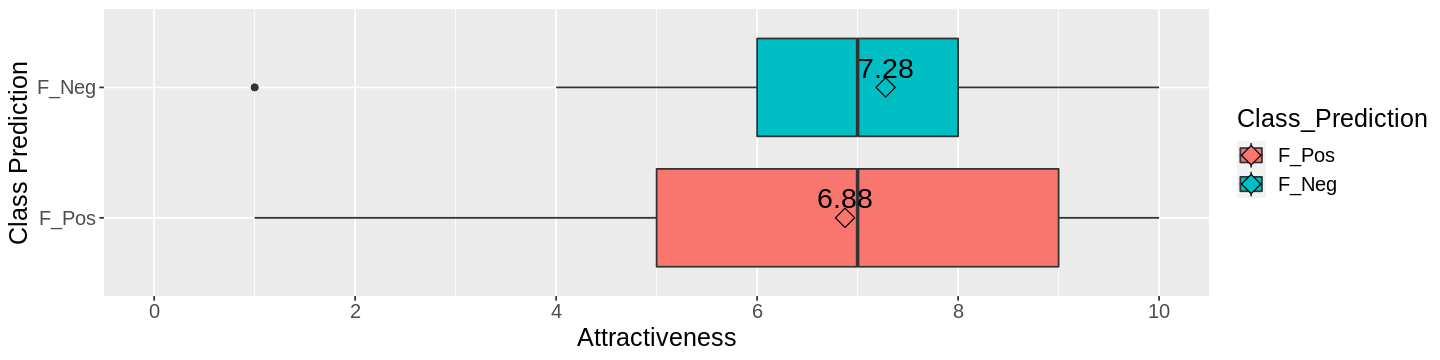

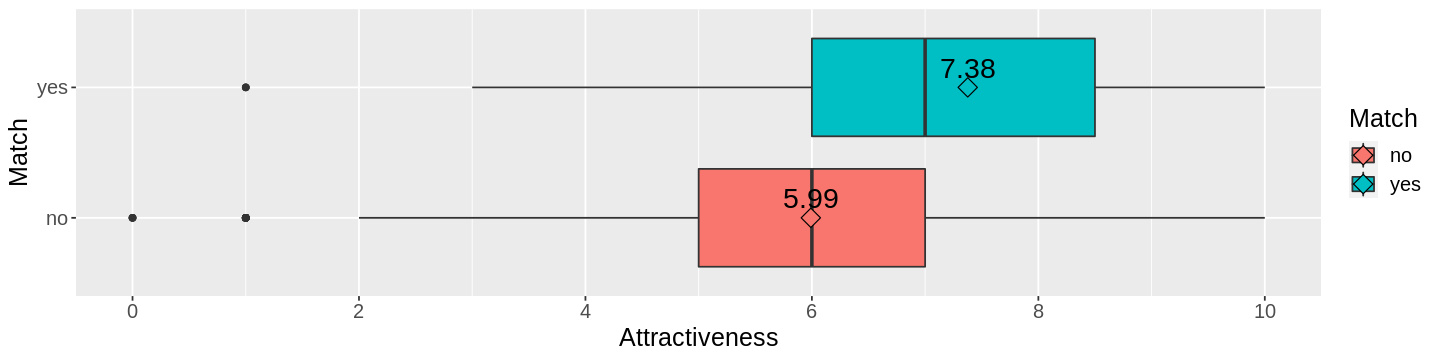

In [139]:
options(repr.plot.width=12, repr.plot.height=3)
false_attr_plot
true_attr_plot
# grid.arrange(false_attr_plot, true_attr_plot,
#              nrow = 2, top = textGrob("False Negatives Plotted", gp=gpar(fontsize=15,font=8)))

### TODO: Create plots for funniness and shared interest, write discussion of what these plots show us

talk about: what do the incorrect predictions tell us about how much the variables actually matter? Maybe some of these variables are not as important as theyseem.

## Discussion

## Summarize what you found

This project allows us to see which variables that correspond to the individuals traits that have a strong relation to how a couple get matched in speed dating.

## Discuss whether this is what you expected to find?

Yes, there are some things that we expected to find. We were expecting variables that are prominent in first impression of a person during speed dating tend to have a stronger relation with how likely the couple get matched than variables that require a deeper understanding of someone.

## Discuss what impact could such findings have?

The project has a potential to help researchers that focus on human relationship to understand which human characters or traits that determine the success rate couple of getting matched in speed dating. This project could be a helpful tool to identify human nature in speed dating. Moreover, this project also gives contribution in the data science field especially K-NN Regression.

## Discuss what future questions could this lead to?




## References